# Test the dependency of the Tikhonov factor choice

## Imports

In [127]:
# Imports for plots

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

# %matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

# Imports from standard packages

from scipy.interpolate import interp1d
from astropy.io import fits
import numpy as np

# Imports for extraction

from extract.overlap import TrpzOverlap

# Local imports

from simulation_utils import load_simu, add_noise

## Load ref files

In [2]:
DEFAULT_PATH = '../jwst-mtl/SOSS/extract/'
DEFAULT_REF_FILES = {'wv_1': 'Ref_files/wavelengths_m1.fits',
                     'wv_2': 'Ref_files/wavelengths_m2.fits',
                     'P_1': 'Ref_files/spat_profile_m1.fits',
                     'P_2': 'Ref_files/spat_profile_m2.fits'}

# Read relevant files
wv_1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_1"])[0].data
wv_2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_2"])[0].data
P1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_1"])[0].data.squeeze()
P2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_2"])[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

## Tests different inputs models

In [3]:
from extract.regularisation import get_nyquist_matrix

In [4]:
models = ["../Simulations/phoenix_teff_02300_scale_1.0e-01.fits",
          "../Simulations/phoenix_teff_06000_scale_1.0e-01.fits",
          "../Simulations/phoenix_teff_09000_scale_1.0e-01.fits"]

Testing factors...
54/54


<IPython.core.display.Javascript object>


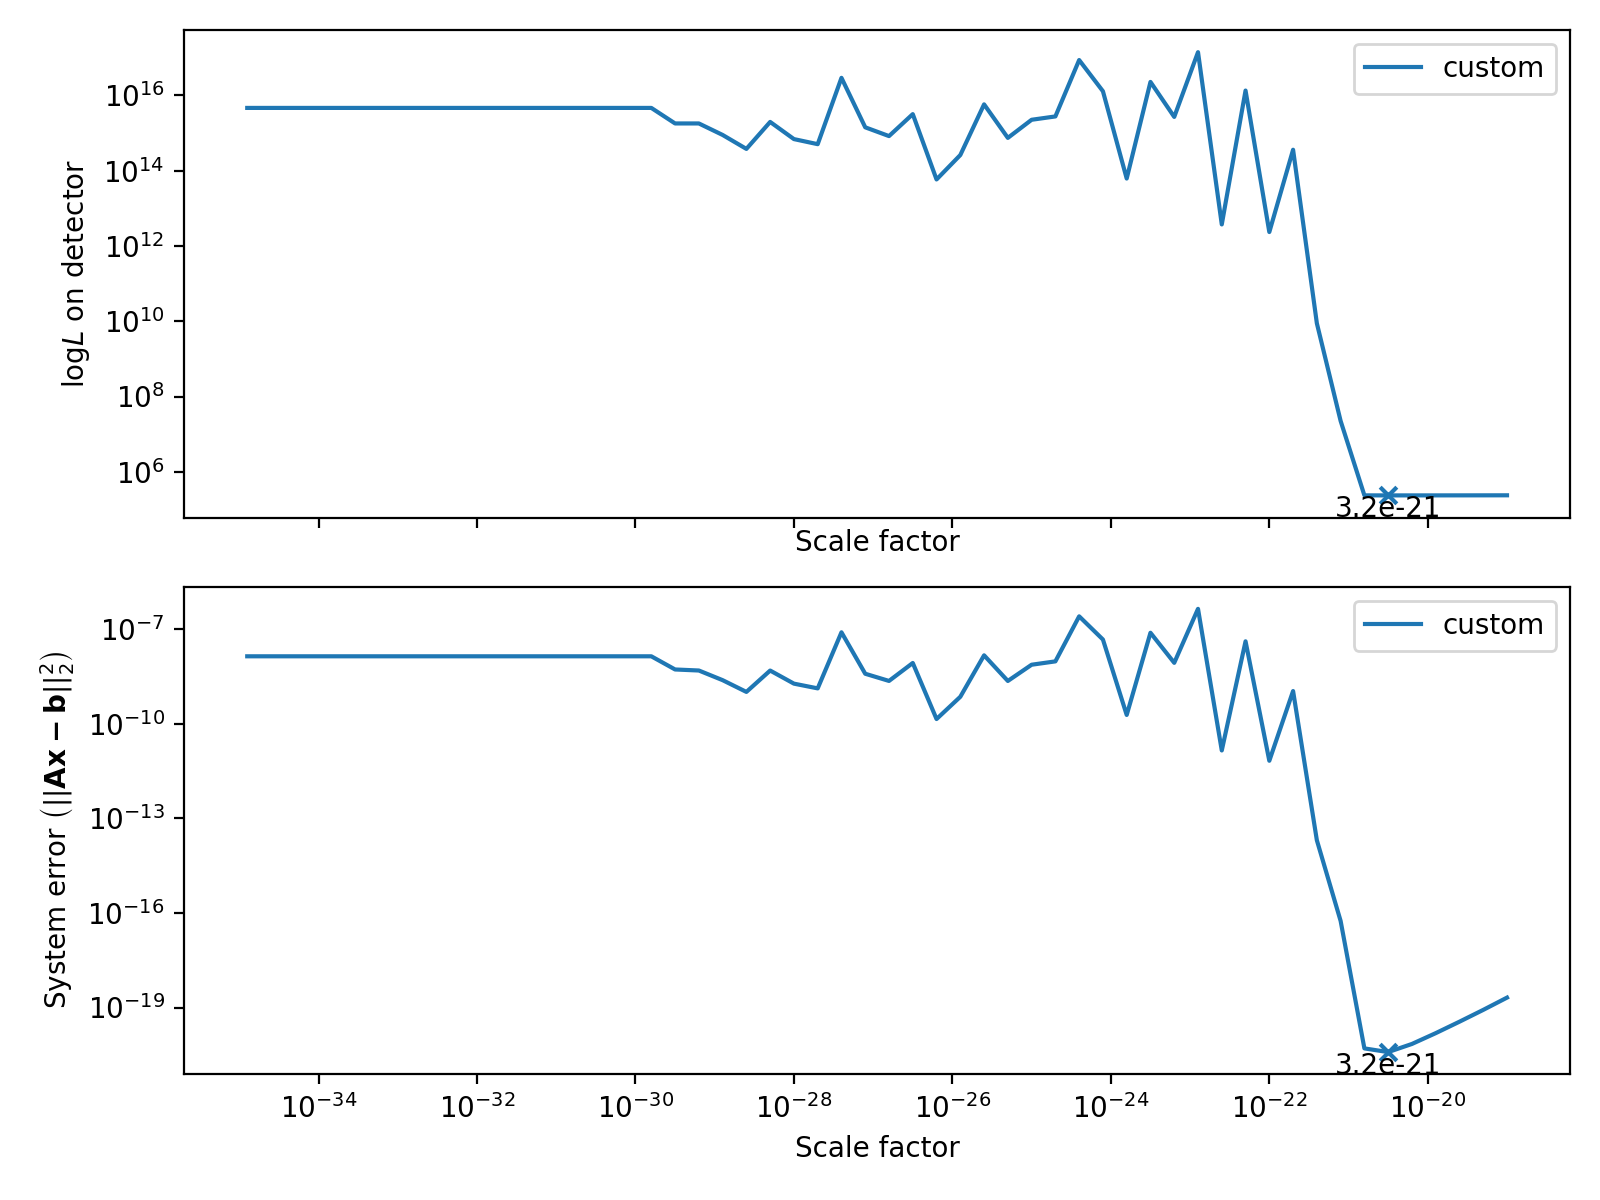

Testing factors...
54/54


<IPython.core.display.Javascript object>


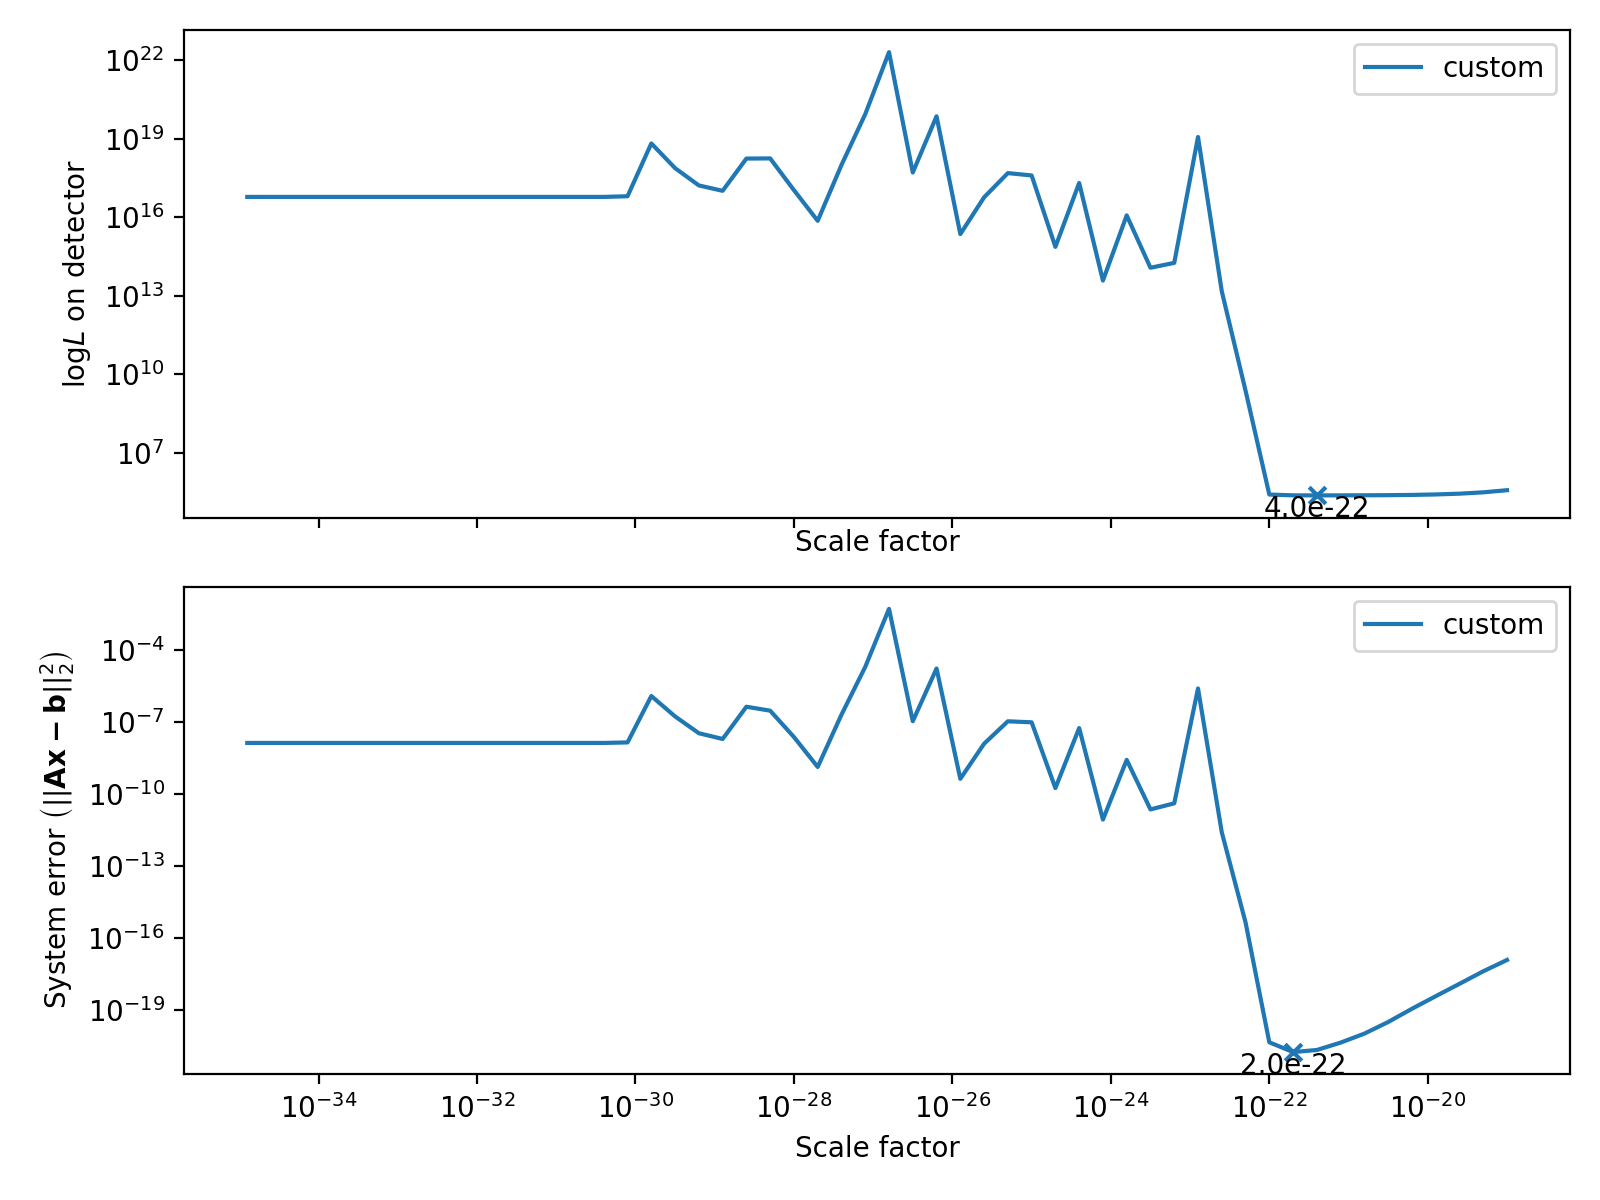

Testing factors...
54/54


<IPython.core.display.Javascript object>


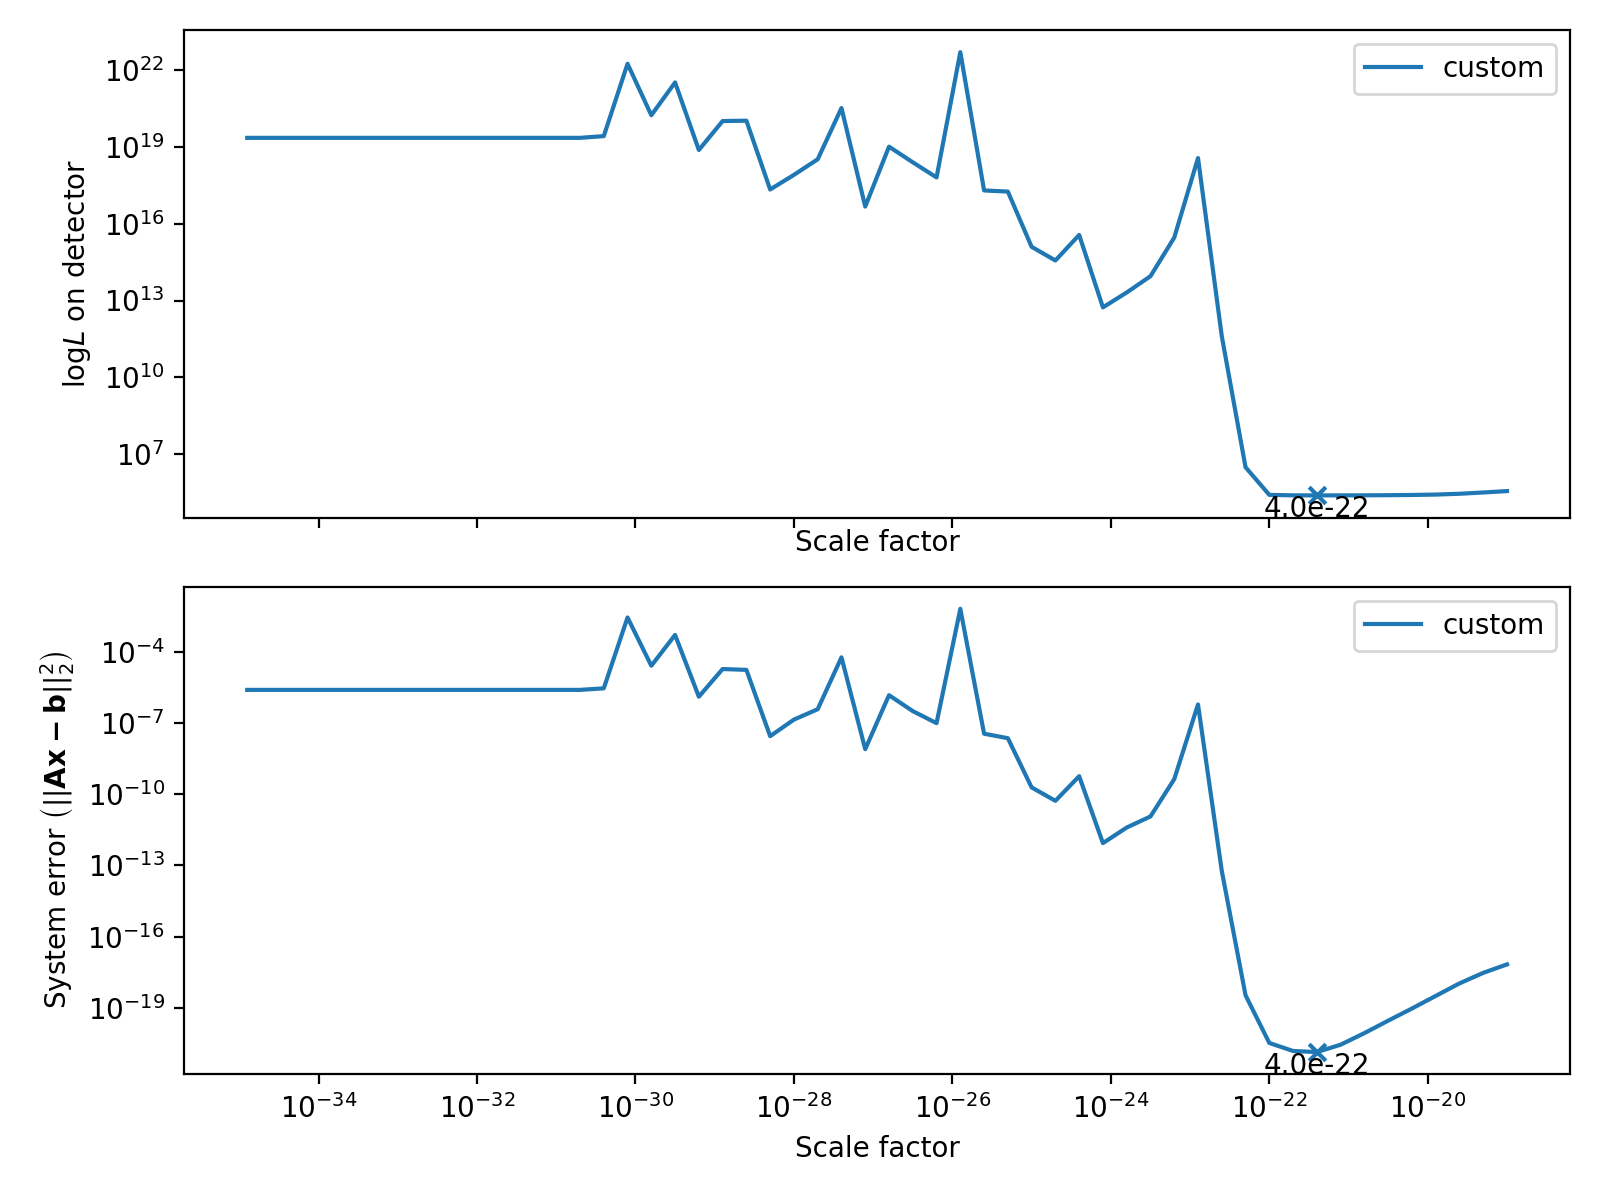

In [6]:
# Extract

for mod in models:
    # Load a simulation
    simu = load_simu(mod)
    scidata = simu["data"]
    sig = np.sqrt(scidata + 20.**2)  # Map of expected noise
    
    extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=scidata, n_os=5,
                    thresh=1e-4, c_kwargs={'thresh':1e-5}, sig=sig)
    t_mat = get_nyquist_matrix(extra.lam_grid, integrate=True)


    factors = 10.**(-1*np.arange(19, 35, 0.3))
    tests = extra.get_tikho_tests(factors, t_mat=t_mat)
    
    extra.plot_tikho_factors()

In [138]:
from scipy.optimize import minimize_scalar
from scipy.interpolate import Akima1DInterpolator

def best_tikho_factor(self, tests=None, interpolate=True,
                      interp_index=[-2, 4], i_plot=False):
    """
    Compute the best scale factor for Tikhonov regularisation.
    It is determine by taking the factor giving the highest logL on
    the detector.
    
    Parameters
    ----------
    tests: dictionnary, optional
        Results of tikhonov extraction tests
        for different factors.
        Must have the keys "factors" and "-logl".
        If not specified, the tests from self.tikho.tests
        are used.
    interpolate: bool, optional
        If True, use akima spline interpolation
        to find a finer minimum. Default is true.
    interp_index: 2 element list, optional
        Index around the minimum value on the tested factors.
        Will be used for the interpolation.
        For example, if i_min is the position of
        the minimum logL value and [i1, i2] = interp_index,
        then the interpolation will be perform between
        i_min + i1 and i_min + i2 - 1
    i_plot: bool, optional
        Plot the result of the minimization

    Returns
    -------
    Best scale factor (float)
    """
    
    # Use pre-run tests if not specified
    if tests is None:
        tests = self.tikho.tests
    
    # Get relevant quantities from tests   
    factors = tests["factors"] 
    logl = tests["-logl"]
    
    # Get position of the minimum value
    i_min = np.argmin(logl)
    
    # Interpolate to get a finer value
    if interpolate:
        # Only around the best value
        i_range = [i_min + d_i for d_i in interp_index]
        # Make sure it's still a valid index
        i_range[0] = np.max([i_range[0], 0])
        i_range[-1] = np.min([i_range[-1], len(logl) - 1])
        # Which index to use
        index = np.arange(*i_range, 1)
        
        # Akima spline in log space
        x_val, y_val = np.log10(factors[index]), np.log10(logl[index])
        i_sort = np.argsort(x_val)
        x_val, y_val = x_val[i_sort], y_val[i_sort]
        fct = Akima1DInterpolator(x_val, y_val)
        
        # Find min
        bounds = (x_val.min(), x_val.max())
        opt_args = {"bounds": bounds,
                    "method": "bounded"}
        min_fac = minimize_scalar(fct, **opt_args).x
        
        # Plot the fit if required
        if i_plot:
            # Original grid
            plt.plot(np.log10(factors), np.log10(logl), ":")
            # Fit sub-grid
            plt.plot(x_val, y_val, ".")
            # Show akima spline
            x_new = np.linspace(*bounds, 100)
            plt.plot(x_new, fct(x_new))
            # Show minimum found
            plt.plot(min_fac, fct(min_fac), "x")
            # Labels
            plt.xlabel(r"$\log_{10}$(factor)")
            plt.ylabel(r"$\log_{10}( - \log L)$")
            plt.tight_layout()
            
        # Return to linear scale
        min_fac = 10.**min_fac
      
    # Simply return the minimum value if no interpolation required
    else:
        min_fac = factors[i_min]
    
    # Return scale factor minimizing the logL
    return min_fac

<IPython.core.display.Javascript object>


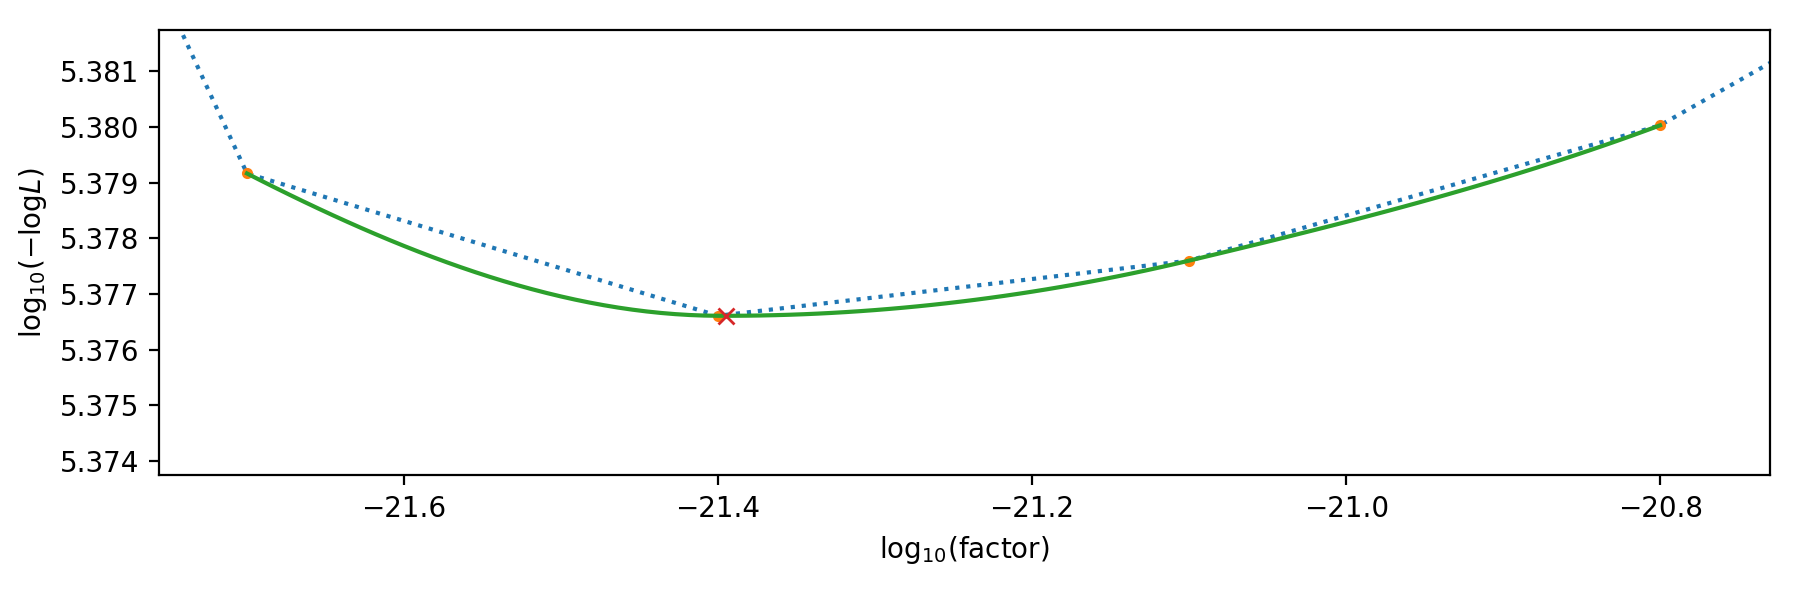

4.026765053865236e-22

In [85]:
best_tikho_factor(extra, tests=tests, i_plot=True)


## For each input model, test different noise level

In [92]:
mod_scales = [[1.0e+04,
               1.0e+08,
               1.0e-01,
               1.0e-03,
               1.0e-05],

              [1.0e+03,
               1.0e+05,
               1.0e+08,
               1.0e-01,
               1.0e-03],

              [1.0e+03,
               1.0e+05,
               1.0e+08,
               1.0e-01,
               1.0e-03]]

In [103]:
"{:1.1e}".format(1e+3)

'1.0e+03'

In [104]:
mod_file = ["../Simulations/phoenix_teff_02300_scale_{:1.1e}.fits",
            "../Simulations/phoenix_teff_06000_scale_{:1.1e}.fits",
            "../Simulations/phoenix_teff_09000_scale_{:1.1e}.fits"]

In [128]:
%matplotlib inline

../Simulations/phoenix_teff_02300_scale_1.0e+04.fits
first guess
Testing factors...
30/30


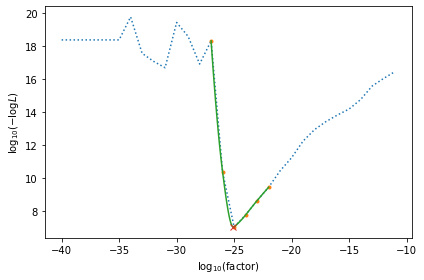

Finer guess
Testing factors...
20/20


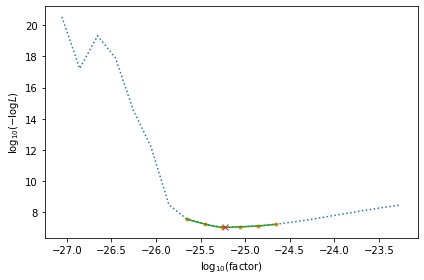

../Simulations/phoenix_teff_02300_scale_1.0e+08.fits
first guess
Testing factors...
30/30


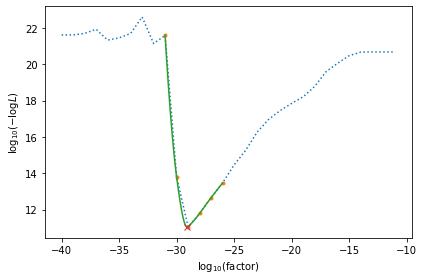

Finer guess
Testing factors...
20/20


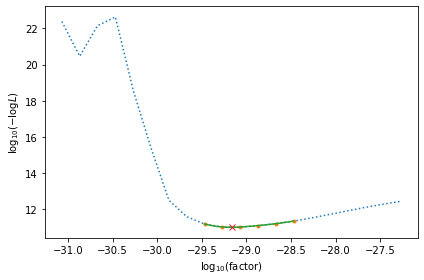

../Simulations/phoenix_teff_02300_scale_1.0e-01.fits
first guess
Testing factors...
30/30


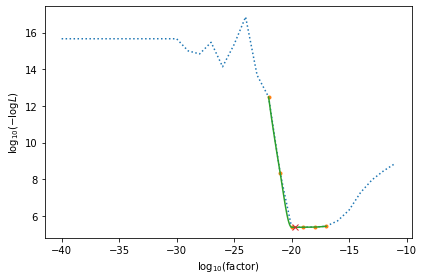

Finer guess
Testing factors...
20/20


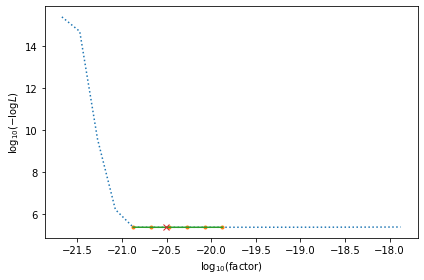

../Simulations/phoenix_teff_02300_scale_1.0e-03.fits
first guess
Testing factors...
30/30


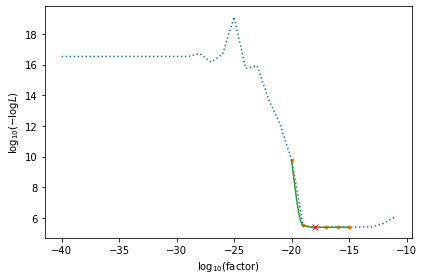

Finer guess
Testing factors...
20/20


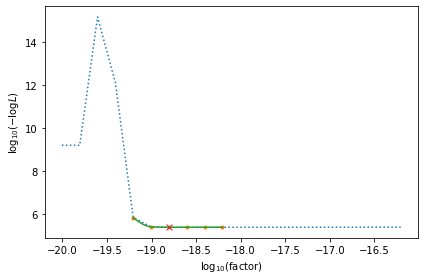

../Simulations/phoenix_teff_02300_scale_1.0e-05.fits
first guess
Testing factors...
30/30


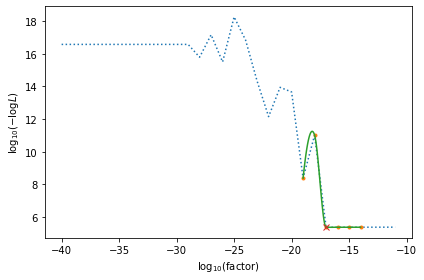

Finer guess
Testing factors...
20/20


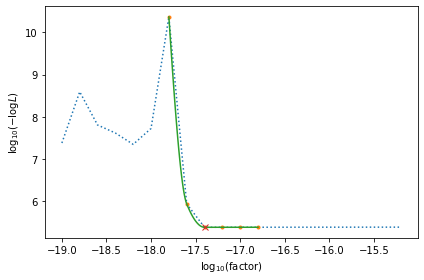

../Simulations/phoenix_teff_06000_scale_1.0e+03.fits
first guess
Testing factors...
30/30


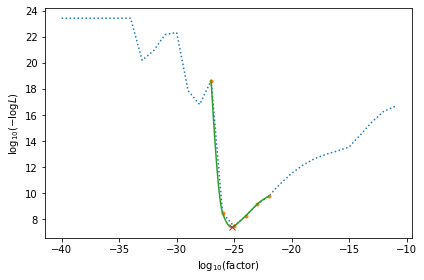

Finer guess
Testing factors...
20/20


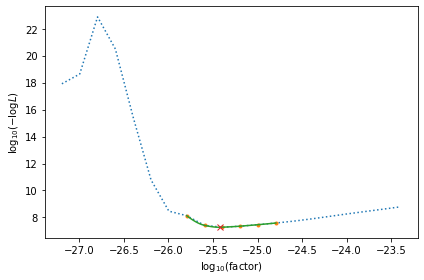

../Simulations/phoenix_teff_06000_scale_1.0e+05.fits
first guess
Testing factors...
30/30


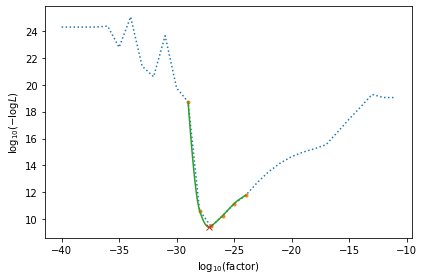

Finer guess
Testing factors...
20/20


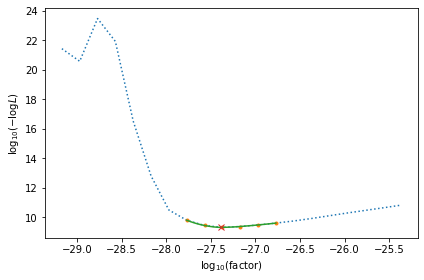

../Simulations/phoenix_teff_06000_scale_1.0e+08.fits
first guess
Testing factors...
30/30


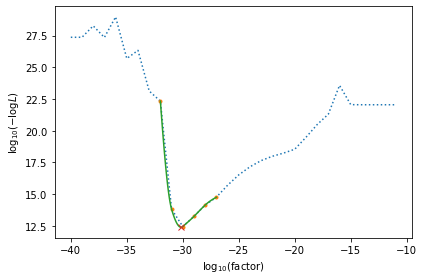

Finer guess
Testing factors...
21/21


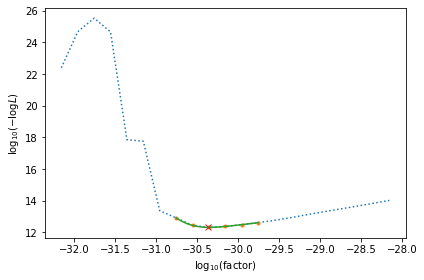

../Simulations/phoenix_teff_06000_scale_1.0e-01.fits
first guess
Testing factors...
30/30


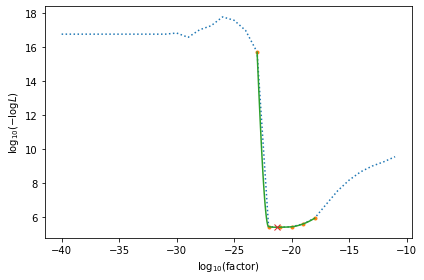

Finer guess
Testing factors...
20/20


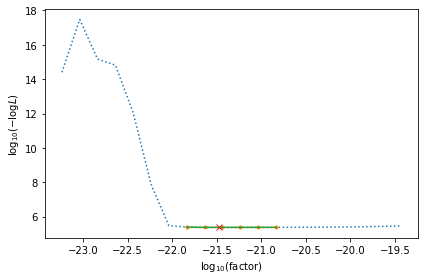

../Simulations/phoenix_teff_06000_scale_1.0e-03.fits
first guess
Testing factors...
30/30


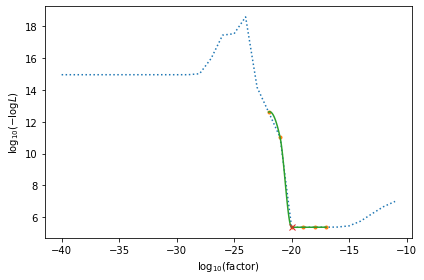

Finer guess
Testing factors...
20/20


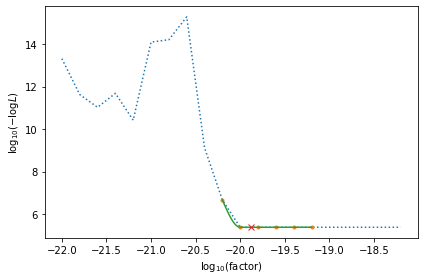

../Simulations/phoenix_teff_09000_scale_1.0e+03.fits
first guess
Testing factors...
30/30


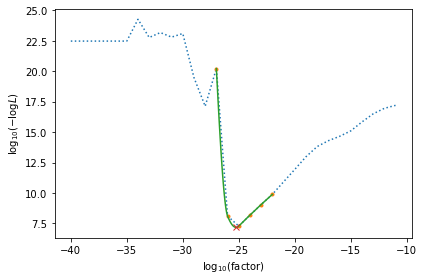

Finer guess
Testing factors...
20/20


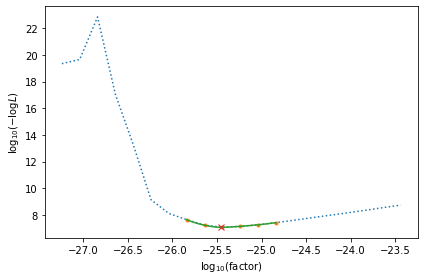

../Simulations/phoenix_teff_09000_scale_1.0e+05.fits
first guess
Testing factors...
30/30


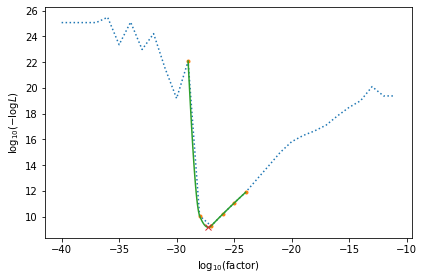

Finer guess
Testing factors...
20/20


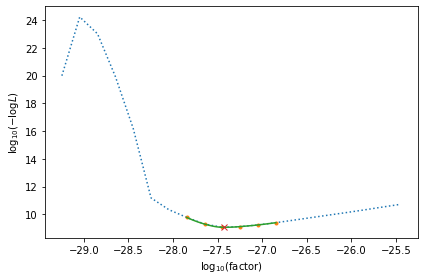

../Simulations/phoenix_teff_09000_scale_1.0e+08.fits
first guess
Testing factors...
30/30


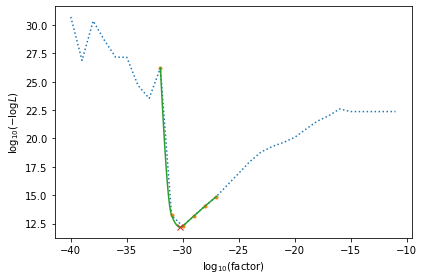

Finer guess
Testing factors...
20/20


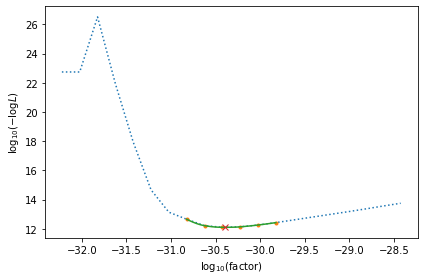

../Simulations/phoenix_teff_09000_scale_1.0e-01.fits
first guess
Testing factors...
30/30


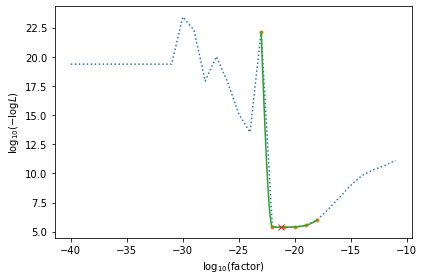

Finer guess
Testing factors...
20/20


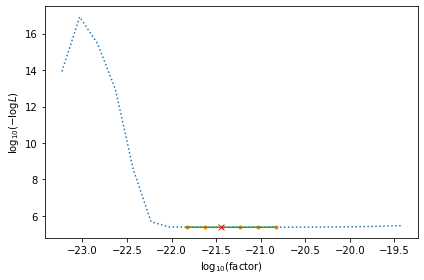

../Simulations/phoenix_teff_09000_scale_1.0e-03.fits
first guess
Testing factors...
30/30


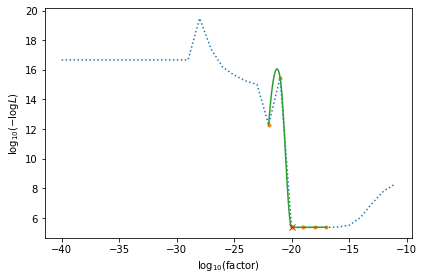

Finer guess
Testing factors...
20/20


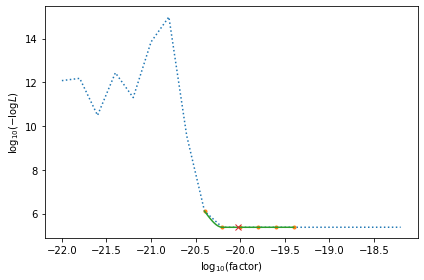

In [139]:
# Extract

best_fac = []
for file_name, scales in zip(mod_file, mod_scales):
    best_fac_i = []
    for scale in scales:
        mod = file_name.format(scale)
        print(mod)
        
        # Load a simulation
        simu = load_simu(mod)
        scidata = simu["data"]
        sig = np.sqrt(scidata + 20.**2)  # Map of expected noise

        extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=scidata, n_os=5,
                        thresh=1e-4, c_kwargs={'thresh':1e-5}, sig=sig)
        t_mat = get_nyquist_matrix(extra.lam_grid, integrate=True)

        # First raw guess of the best factor
        print("first guess")
        factors = 10.**(np.arange(-40, -10, 1))
        tests = extra.get_tikho_tests(factors, t_mat=t_mat)
        plt.figure()
        min_fac = best_tikho_factor(extra, tests=tests, i_plot=True)
        plt.show()
        
        # Finer guess
        print("Finer guess")
        min_fac = np.log10(min_fac)
        factors = 10.**(np.arange(min_fac-2, min_fac+2, 0.2))
        tests = extra.get_tikho_tests(factors, t_mat=t_mat)
        plt.figure()
        min_fac = best_tikho_factor(extra, tests=tests, i_plot=True)
        plt.show()
        
        # Save
        best_fac_i.append(min_fac)
        
    # Save
    best_fac.append(np.array(best_fac_i))

In [151]:
%matplotlib notebook

In [206]:
def get_snr(self, q_range=[0.9, 1.], data=None, mask=None, noise=None):
    
    # Use object attributes if not given
    if data is None:
        data = self.data
        
    if mask is None:
        mask = self.mask
        
    if noise is None:
        noise = self.sig
        
    # Define array of pixels with signal
    pix = data[~mask]
    # and corresponding noise estimate
    pix_noise = noise[~mask]
        
    # Find quantile
    q_min = np.quantile(pix, q_range[0])
    q_max = np.quantile(pix, q_range[1])
    
    # Use pixels above quantile
    i_good = (q_min <= pix) & (pix <= q_max)
    
    # Compute snr
    snr = pix[i_good] / pix_noise[i_good]
    
    # Return mean
    return snr.mean()

In [215]:
snr = []
for file_name, scales in zip(mod_file, mod_scales):
    snr_i = []
    for scale in scales:
        mod = file_name.format(scale)
        
        # Load a simulation
        simu = load_simu(mod)
        data = simu["data"]
        sig = np.sqrt(scidata + 20.**2)  # Map of expected noise
        snr_i.append(get_snr(extra, data=data, noise=sig, q_range=[0.75, 1.0]))
    snr.append(snr_i)

<IPython.core.display.Javascript object>


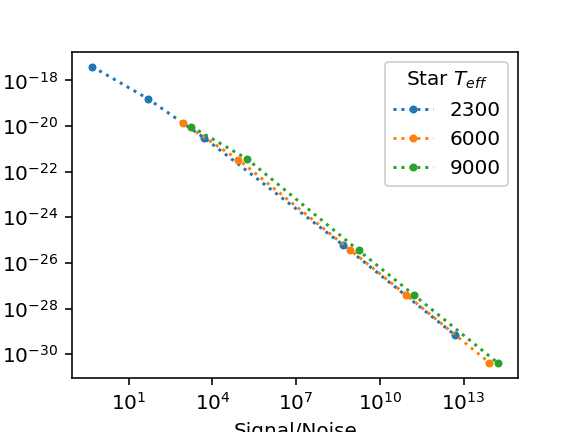

[-0.70431914 -0.85132651 -0.94227907 -0.98446765]
[-0.80022217 -0.98659533 -0.98053939 -0.9957226 ]
[-0.70880631 -1.00296543 -0.98430381 -0.99009758]


Text(0, 0.5, 'Best Tikhonov factor')

In [216]:
plt.figure(figsize=(4, 3))
for snr_i, best_f in zip(snr, best_fac):
    i_sort = np.argsort(snr_i)
    snr_i = np.array(snr_i)
#     print(scales[i_sort])
#     print(best_f[i_sort])
    plt.loglog(snr_i[i_sort], best_f[i_sort],".:")
    print(np.diff(np.log10(best_f[i_sort]))/np.diff(np.log10(snr_i[i_sort])))

lines = plt.gca().get_lines()
plt.legend(lines, [2300, 6000, 9000], title=r"Star $T_{eff}$")
plt.xlabel("Signal/Noise")
plt.ylabel("Best Tikhonov factor")

<IPython.core.display.Javascript object>


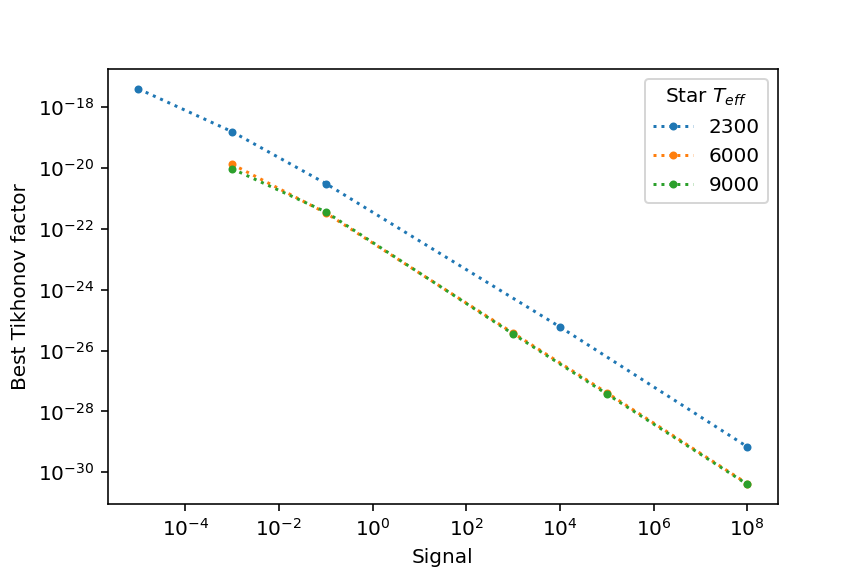

[-0.70341661 -0.85133042 -0.94228008 -0.98446765]
[-0.80022158 -0.98659529 -0.98053939 -0.9957226 ]
[-0.70880653 -1.00296544 -0.98430381 -0.99009758]


Text(0, 0.5, 'Best Tikhonov factor')

In [185]:
for scales, best_f in zip(mod_scales, best_fac):
    i_sort = np.argsort(scales)
    scales = np.array(scales)
#     print(scales[i_sort])
#     print(best_f[i_sort])
    plt.loglog(scales[i_sort], best_f[i_sort],".:")
    print(np.diff(np.log10(best_f[i_sort]))/np.diff(np.log10(scales[i_sort])))

lines = plt.gca().get_lines()
plt.legend(lines, [2300, 6000, 9000], title=r"Star $T_{eff}$")
plt.xlabel("Signal")
plt.ylabel("Best Tikhonov factor")

In [167]:
f_k = np.ones(extra.n_k)
f_k[extra.i_grid] = tests["solution"][10]

In [169]:
rebuilt = extra.rebuild(f_k)

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


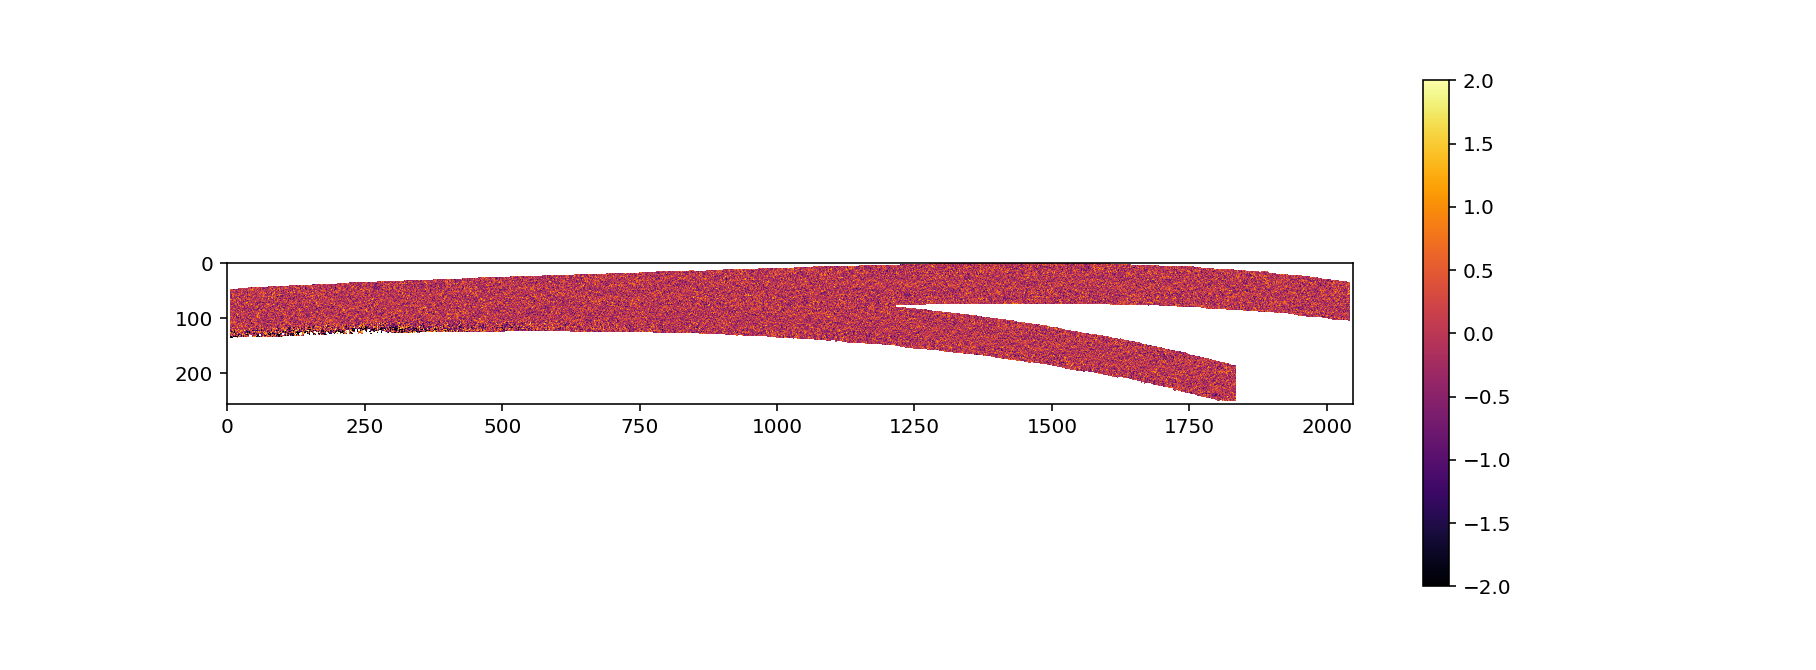

In [172]:
plt.imshow((extra.data - rebuilt)/np.sqrt(extra.data), vmin=-2, vmax=2)
plt.colorbar()